In [1]:
import numpy as np
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import copy
from scipy.stats import spearmanr
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')
#data = data.neg_sample(frac = 1)
data = data.get_data()


Found local copy...
Loading...
Done!


In [2]:
data_train, data_test = train_test_split(data, test_size=0.1, shuffle=True)

In [3]:
proteins = list(set(data.Protein1_ID).union(set(data.Protein2_ID)))
proteins_map = dict(zip(proteins, range(len(proteins))))

In [4]:
len(proteins)

8248

In [5]:
print(len(data), len(proteins))

52369 8248


In [6]:
Network_train = [[] for i in range(len(proteins))]
for i in range(len(data_train)):
    p1 = proteins_map[data_train.iloc[i,0]]
    p2 = proteins_map[data_train.iloc[i,2]]
    
    Network_train[p1].append(p2)
    Network_train[p2].append(p1)

In [7]:
train_pos = np.array([[proteins_map[data_train.iloc[i,0]], proteins_map[data_train.iloc[i,2]], 1] for i in range(len(data_train))])
train_pos_sparseM = csr_matrix((train_pos[:,2],(train_pos[:,0],train_pos[:,1])), shape=(len(proteins),len(proteins)))
train_pos_sparseM[train_pos[:,1],train_pos[:,0]] = train_pos[:,2] #symmetric
#(data, (row_ind, col_ind)

In [8]:
np.savetxt("train_pos", train_pos)

In [9]:
np.unique(np.array(train_pos_sparseM.todense()).flatten())

array([0, 1], dtype=int64)

In [10]:
train_pos_sparseM[575,771], train_pos_sparseM[771,575], train_pos_sparseM[0,0]

(0, 0, 0)

In [11]:
test_pos = np.array([[proteins_map[data_test.iloc[i,0]], proteins_map[data_test.iloc[i,2]], 1] for i in range(len(data_test))])
test_negrandom = np.asarray([np.random.choice(len(proteins), len(data_test)), np.random.choice(len(proteins), len(data_test)), np.zeros(len(data_test))]).transpose().astype(int)
test = np.append(test_pos, test_negrandom, axis=0)

In [12]:
np.savetxt("test", test)

In [13]:
def semantic_train_ising(Network, Jeff, d = 10000, n_iter=100):
    n = len(Network)
    HDV = np.random.choice([1,-1], size=(n,d))
    y_test_true = test[:,2]
    y_test_predicted = [cosine_similarity(HDV[test[i,0],:].reshape(1, -1), HDV[test[i,1],:].reshape(1, -1))[0,0] for i in range(len(test))]
    auc= roc_auc_score(y_test_true, y_test_predicted)
    con = auc
    conver = []
    for montecarlostep in range(n_iter):
        for randomspinselection in range(n):
            s = np.random.choice(range(n))
            neighbors = Network[s]
            dE = 2*HDV[s,:]*Jeff*np.sum(HDV[neighbors,:], axis=0)
            dE[dE<0]=-5
            Pflip = np.exp(-dE)
            HDV[s, np.where(Pflip > np.random.random(d))] *=-1
        y_test_true = test[:,2]
        y_test_predicted = [cosine_similarity(HDV[test[i,0],:].reshape(1, -1), HDV[test[i,1],:].reshape(1, -1))[0,0] for i in range(len(test))]
        auc= roc_auc_score(y_test_true, y_test_predicted)
        con_new = auc    
        conver.append(con_new)
        con = con_new
    return HDV , conver

In [14]:
test

array([[1009, 1271,    1],
       [7838, 2711,    1],
       [2097, 6483,    1],
       ...,
       [6306, 2914,    0],
       [8050, 3011,    0],
       [8146, 5567,    0]])

training time for embedding:  1.7914628505706787 minutes
shape of embedded:  (8248, 10000)
auc on test set, with prediction cosine similarity of embeddings:  0.8981475320158641


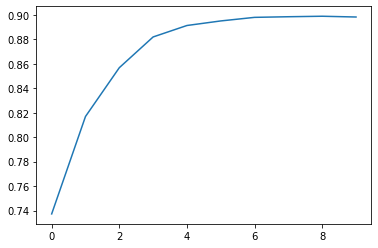

In [15]:
a = time.time()
HDV, conver = semantic_train_ising(Network_train, Jeff=0.1, d = 10000, n_iter=10)
b = time.time()
print('training time for embedding: ', (b-a)/60, 'minutes')
print('shape of embedded: ', HDV.shape)
plt.plot(conver)

y_test_true = test[:,2]
y_test_predicted = [cosine_similarity(HDV[test[i,0],:].reshape(1, -1), HDV[test[i,1],:].reshape(1, -1))[0,0] for i in range(len(test))]
auc= roc_auc_score(y_test_true, y_test_predicted)

print('auc on test set, with prediction cosine similarity of embeddings: ', auc)

In [16]:
HDV.shape, HDV

((8248, 10000),
 array([[ 1, -1,  1, ..., -1,  1, -1],
        [ 1,  1,  1, ..., -1, -1,  1],
        [ 1,  1, -1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ..., -1, -1,  1],
        [ 1, -1, -1, ...,  1, -1,  1],
        [ 1,  1,  1, ..., -1, -1,  1]]))

In [17]:
def calc_E(HDV, Network, Jeff):
    E=0
    for i in range(HDV.shape[0]):
        neighbors = Network[i]
        E+=-HDV[i,:]*Jeff*np.sum(HDV[neighbors,:], axis=0)
    print(E.shape)
    return np.mean(E)/HDV.shape[0]
def calc_M(HDV):
    return np.mean(np.abs(np.mean(HDV, axis=0)))

In [25]:
Js = 10**np.linspace(-3,2,20)
aucs = []
Ms = []
Es = []
for J in Js:
    print(J)
    HDV, conver = semantic_train_ising(Network_train, Jeff=J, d = 10000, n_iter=10)

    y_test_true = test[:,2]
    y_test_predicted = [cosine_similarity(HDV[test[i,0],:].reshape(1, -1), HDV[test[i,1],:].reshape(1, -1))[0,0] for i in range(len(test))]
    auc= roc_auc_score(y_test_true, y_test_predicted)

    aucs.append(auc)
    Ms.append(calc_M(HDV))
    Es.append(calc_E(HDV, Network_train, 1))

0.001
(10000,)
0.0018329807108324356
(10000,)
0.003359818286283781
(10000,)
0.006158482110660267
(10000,)
0.011288378916846888
(10000,)
0.02069138081114789
(10000,)
0.0379269019073225
(10000,)
0.06951927961775606
(10000,)
0.12742749857031335
(10000,)
0.23357214690901212
(10000,)
0.42813323987193913
(10000,)
0.7847599703514607
(10000,)
1.438449888287663
(10000,)
2.636650898730358
(10000,)
4.832930238571752
(10000,)
8.858667904100823
(10000,)
16.23776739188721
(10000,)
29.763514416313193
(10000,)
54.555947811685144
(10000,)
100.0
(10000,)


0.9012676907226816


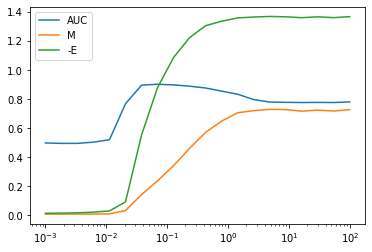

In [35]:
fig = plt.plot(Js, aucs, label="AUC")
plt.plot(Js, Ms, label="M")
plt.plot(Js, -np.array(Es)/8, label="-E")
print(max(aucs))
plt.xscale("log")
plt.legend()
plt.savefig("phase_transition.png")